Описание данных:
- age - возраст покупателей
- DebtRatio - отношение месячных платежей к суммарному месячному доходу
- NumberOfTime30-59DaysPastDueNotWorse - число случаев, когда клиент просрочил выплату на 30-59 дней
- NumberOfTimes90DaysLate - число случаев, когда клиент просрочил на 90+ дней кредит
- NumberOfTime60-89DaysPastDueNotWorse - число случаев, когда клиент просрочил кредит на 60-89 дней
- NumberOfDependents - число иждивенцев
- SeriousDlqin2yrs - целевая переменна

In [1]:
# импортируем необходимые библиотеки
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# загрузим данные
data = pd.read_csv('credit_scoring.csv')
data.head()

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,0,64,0,0.249908,0,0,8158.0,0.0
1,0,58,0,3870.000000,0,0,NaN,0.0
2,0,41,0,0.456127,0,0,6666.0,0.0
3,0,43,0,0.000190,0,0,10500.0,2.0
4,1,49,0,0.271820,0,0,400.0,0.0


Distribution of the target:


0    0.777511
1    0.222489
Name: SeriousDlqin2yrs, dtype: float64

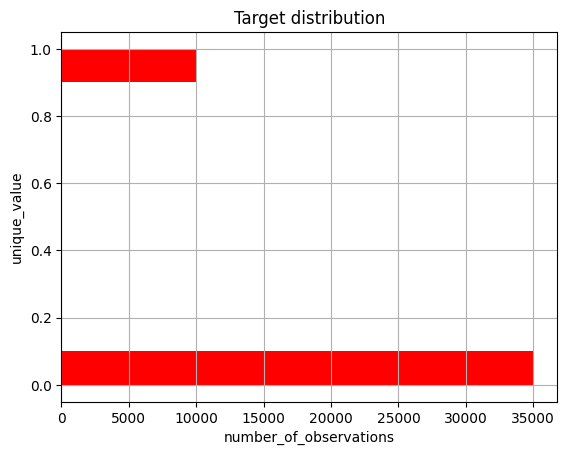

In [3]:
# Посмотрим как выглядит распределение целевой переменной
ax = data['SeriousDlqin2yrs'].hist(orientation='horizontal', color='red')
ax.set_xlabel("number_of_observations")
ax.set_ylabel("unique_value")
ax.set_title("Target distribution")

print('Distribution of the target:')
data['SeriousDlqin2yrs'].value_counts()/data.shape[0]

In [4]:
cols_fill = [col for col in data.columns if col != "SeriousDlqin2yrs"]
for c in cols_fill:
    data[c] = data[c].fillna(data[c].median())

In [5]:
X = data[cols_fill]
y = data['SeriousDlqin2yrs']

In [12]:
lr = LogisticRegression(random_state=13, class_weight='balanced', solver='liblinear')
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)

parameters = {'C': (0.0001, 0.001, 0.01, 0.1, 1, 10)}

gs = GridSearchCV(estimator=lr, param_grid=parameters,cv=skf)